# Monte Carlo Scheduler
#### Predicting duration for completion of future tasks based on knowledge estimates from historical data 
This simple program utilises a primitive linear regression model for prediction of actual time for completion of tasks based on the estimates provided by randomly sampling data from historical records to run a simulation over $n$ iterations, resulting in a list of predictions grouped with their count of occurences from which confidence values can be computed for each prediction. Thus in a typical Monte Carlo Simulation, greater the confidence, greater becomes the probability for better prediction and greater the number of trials, greater becomes the accuracy. 

### Sample Datasets used for this Simulation

In [108]:
import pandas as pd
print("HISTORICAL TASK DATA")
print(pd.read_csv('historical.csv'))
print()
print("FUTURE TASK DATA")
print(pd.read_csv('future.csv'))

HISTORICAL TASK DATA
   Task Name  Estimate  Actual
0     Task 1        10      12
1     Task 2         8      12
2     Task 3        10      16
3     Task 4         8      10
4     Task 5         8      16
5     Task 6         8      14
6     Task 7        12      16
7     Task 8        16      24
8     Task 9         8      16
9    task 10        12      24
10   task 11        20      24
11   task 12        14      20
12   task 13         8      10
13   task 14        12      14
14   task 15        16      12
15   task 16        20      24
16   task 17         8      12
17   task 18        12      12
18   task 19        24      26
19   task 20        20      24
20  Task 21"        16      16
21   task 22         8       9
22   task 23        20      23
23   task 24         8       8

FUTURE TASK DATA
   Task Name  Estimate
0     Task 1         2
1     Task 2        19
2     Task 3         2
3     Task 4        11
4     Task 5        32
5     Task 6         3
6     Task 7         2
7 

## Imports

In [109]:
import csv
import math
from random import *
from matplotlib.pyplot import *

## Loading the Datasets
The CSV files for the scheduling task is loaded by the following function, which generalises the loading and parsing of .csv files into nested list of records, better suited for data transformation and manipulation. `Pandas.read_csv()` can also be used to do the same. 


In [110]:
# CSV LOADER
def loadCSV(filename):
	hasHeaders=False
	with open(filename) as csvfile:
		output = []
        # sample head buffer to explore .csv paramaters
		sample = csvfile.read(1024) 
        # check if .csv has headers
		hasHeaders = csv.Sniffer().has_header(sample)
        # get encoding parameters in .csv
		dialect = csv.Sniffer().sniff(sample)
        # move cursor to start of .csv
		csvfile.seek(0)
        # begin reading .csv with scanned parameters
		reader = csv.reader(csvfile,dialect)
        # skip the header row in .csv
		firstLine = True
		for row in reader:
			if (hasHeaders and firstLine):
				firstLine = False
			else:
                # parse each record based on type
				record = []
				for col in row:
					if col.isnumeric():
						record.append(int(col))
					else:
						record.append(col)
                # append parsed record to output
				output.append(record)
		return (output)  
# DATASET LOADER    
def loadData(historicalFilename, futureFilename):
	historical 	= loadCSV(historicalFilename)
	future 		= loadCSV(futureFilename)
	hasHeaders=False
	return(historical, future)

## Running the Simulations
> #### Monte Carlo Method
> A Monte Carlo Simulation is a way of approximating the value of a function where calculating the actual value is difficult or impossible. It uses random sampling to define constraints on the value and then makes a sort of "best guess."
> It works by the **Principle of Large Numbers** which states that
> > ***“As the number of identically distributed, randomly generated variables increases, their sample mean (average) approaches their theoretical mean.”***
> 
> The functions for carrying out these simulations are elaborated below.

### Simulator Functions

Function to run $one$ simulation.<br> Mathematically, it computes the following expression.

$\bigg(\frac{{sample(history)}_{actual}}{{sample(history)}_{estimated}}\bigg)\times{future}_{estimated}$
```
Runs 1 simulation of future data based on historical data.
Input:  historical 	= list of lists in the format: [[TaskName, estimated, actual], ...]
        future 		= list of lists in the format: [[TaskName, estimated], ...]
```

In [111]:
def runSimulation(historical,future):
	predictedTotal=0
	for task in future:
		selectedEvent = historical[randint(0,len(historical)-1)]
		velocity = selectedEvent[2]/selectedEvent[1]
		predicted = velocity*task[1]
		predictedTotal+=predicted
		task.append(predicted)
	predictedTotal=round(predictedTotal,2)
	return (predictedTotal)

Function to run $N$ simulations.
```
Runs n simulations of future data based on historical data.
Input:  historical 	= list of lists in the format: [[TaskName, estimated, actual], ...]
        future 		= list of lists in the format: [[TaskName, estimated], ...]
        n 			 = number of simulations to run
```

In [112]:
def runSimulations(historical,future,n=1,verbose=False):
	estTotal=0
	predictions=[]
	for task in future:
		estTotal+=task[1]
	print("Total Hours Estimated: "+str(estTotal))
	for i in range(0,n):
		predictedTotal = runSimulation(historical,future)
		predictions.append(predictedTotal)
		if (verbose):
			print ("Trial {0:2} prediction: {1:.0f} ({2:.2f}% of estimated)".format(i,predictedTotal,100*predictedTotal/estTotal))
	print("Takes a Minimum of {0:.0f} hours for all tasks to complete. ({1:.2f}% of estimated hours)".format(min(predictions),100*min(predictions)/estTotal))
	print("Takes a Maximum of {0:.0f} hours for all tasks to complete. ({1:.2f}% of estimated hours)\n".format(max(predictions),100*max(predictions)/estTotal))
	return(sorted(predictions))

### Functions for Probablistic Conversion
These functions count for the probability of occurence of each prediction, which is later used for plotting the predictions against the perfect estimate as the confidence reaches its peak (*i.e. Simulations completed nears the value of $N$*)

#### Summarize Function
```
Input: List of predictions
Output: Nested lists of prediction and their count
```

In [113]:
def summarize(data):
	points = []
	output=[]
	for p in data:
		if (p not in points):
			points.append(p)
	for p in points:
		c = data.count(p)
		output.append([p,c])
	return(output)

#### Confidence Computing Function
```
Input: Prediction counts, nested lists of format [[prediction, count],...]
Output: Predictions with confidence percentages of format [[prediction, percent],...]
```

In [114]:
def computeConfidence(data,verbose=False):
	trialsSoFar=0
	totalTrials = sum([predWithTrials[1] for predWithTrials in data])
	if (verbose):
		print("Total trials: {0}".format(totalTrials))
	confidenceRatings=[]
	for prediction in data:
		trialsSoFar+=prediction[1]
		confidence = float(trialsSoFar)/float(totalTrials)*100
		if (verbose):
			print("Prediction: {0} (Confidence: {1:.2f}%)".format(prediction[0],confidence))
		confidenceRatings.append([prediction[0],confidence])
	return(confidenceRatings)

### Model Runner
```
Input: Historical and Future data
Output: Ascending Ordered Predictions with confidence in format: [[predicted, confidence percent],...]
		(Interpreted as "C% completion chance for P")
```

In [115]:
# MODEL RUNNER FROM FILE (STEP--1)
def runModelFromFiles(historicalFilename,futureFilename,trials=10000,plot=True):
	historical, future 	= loadData(historicalFilename,futureFilename)
	return runModelFromData(historical,future,trials,plot)
# MODEL RUNNER FROM DATA (STEP--2)
def runModelFromData(historical,future,trials=10000,plot=False):
	print("Running {0} trials.".format(trials))
	matplotlib.pyplot.clf()
	simulationData 		= runSimulations(historical, future,trials)
	summaryData 		= summarize(simulationData)
	confidenceData 		= computeConfidence(summaryData)
	perfectEstimate = sum([item[1] for item in future])
	if (plot == True):
		plotPredictions(confidenceData,perfectEstimate)        
	return(confidenceData,perfectEstimate)

### Model Plotter

In [116]:
def plotPredictions(confidenceData,estimated=None,xLabel="Hours",yLabel="% of Simulations Complete",chartType="plot"):
	x = [item[0] for item in confidenceData]
	y = [item[1] for item in confidenceData]
	matplotlib.pyplot.title('{0} and {1}'.format(xLabel,yLabel))
	if (len(y)<10):
		lefts = [v-.5 for v in x]
		matplotlib.pyplot.ylim(0,110)
		matplotlib.pyplot.bar(lefts,y,width=((max(x)-min(x))/(len(x)-1)))
		if (estimated is not None):
			x.append(estimated)
		matplotlib.pyplot.xticks(x)
	else:
		matplotlib.pyplot.ylim(-10,110)
		matplotlib.pyplot.plot(x,y)
	matplotlib.pyplot.xlabel(xLabel)
	matplotlib.pyplot.ylabel(yLabel)
	matplotlib.pyplot.show()

### Model Execution

Running 10000 trials.
Total Hours Estimated: 377
Takes a Minimum of 409 hours for all tasks to complete. (108.43% of estimated hours)
Takes a Maximum of 619 hours for all tasks to complete. (164.15% of estimated hours)



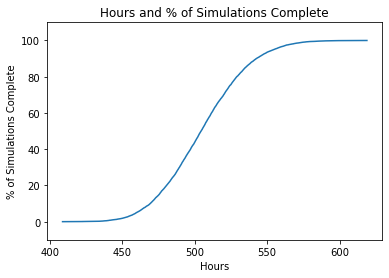

In [117]:
def main():
    runModelFromFiles('historical.csv','future.csv')
main()